# 9. Dueling DQN
- DQN 算法敲开了深度强化学习的大门，但是作为先驱性的工作，其本身存在着一些问题以及一些可以改进的地方。于是，在 DQN 之后，学术界涌现出了非常多的改进算法...

其中有两个非常著名的算法：**Double DQN 和 Dueling DQN**
本节学习 **Dueling DQN** --- [Dueling Network Architectures for Deep Reinforcement Learning](https://arxiv.org/abs/1511.06581)
(更多、更详细的 DQN 改进方法，见 Rainbow 模型的论文及其引用文献 --- [Rainbow: Combining Improvements in Deep Reinforcement Learning](https://arxiv.org/abs/1710.02298)

## 9.1 Dueling DQN 原理
根据前期的学习可知:在同一状态下,**所有动作**的动作价值的期望就是**该状态**的状态价值
那么完全可以将 **状态价值** 剥离出来
将 **状态动作价值函数Q** 减去 **状态价值函数V** 的结果定义为 **优势函数A** :$A(s,a)=Q(s,a)-V(s)$
该函数可以独自表达各个动作在同一状态下的 **差异**，即衡量在状态 s 下选择动作 a 相对于平均水平的好坏

> 实际上原始的DQN算法Q值也有大小之分,那么为何要多此一举定义一个独自表达差异的函数呢?

本质上是要提升网络学习效率和泛化能力:
- 不是所有状态都需要区分动作(核心)：如在 Atari 游戏中，角色正处于安全区，向左/向右/跳跃都不会立即影响得分，但原始 DQN 仍要为每个动作分别拟合 Q 值
- 更结构化，对动作多差异小的状态更有优势：分离状态与差异,根据实际情况有选择的关注(当智能体前面没有车时，车辆自身动作并没有太大差异，此时智能体更关注状态价值；而当智能体前面有车时（智能体需要超车），智能体开始关注不同动作优势值的差异)

![状态价值和优势值的简单例子](Illustrations/状态价值和优势值的简单例子.png)


在 Dueling DQN 中，Q 网络被重建为：
$$Q_{\eta,\alpha,\beta}(s,a)=V_{\eta,\alpha}(s)+A_{\eta,\beta}(s,a)$$
#### 参数说明:
$\eta$(整个函数近似器（神经网络）的共享参数)：在 Dueling DQN 网络中，该参数是整个函数近似器（神经网络）的共享参数，用于前面几层提取共享状态的表示
$\alpha$：专用于拟合状态价值函数的网络分支的参数，而该网络从共享特征中抽取更专注于“状态本身”的信息
$\beta$：专用于拟合优势函数的网络分支的参数，该网络主要用于捕捉特定动作的相对优势

以下为网络结构对比图：
![DQN与Dueling%20DQN网络结构](Illustrations/DQN与Dueling%20DQN网络结构.jpg)
- 同时如此设计Q网络，可以使每一次更新时，函数都会被更新，这也会影响到其他动作的Q值(传统的 DQN 只会更新某个动作的值) 

因此，Dueling DQN 能够更加频繁、准确地学习状态价值函数

#### 不唯一性的问题：
##### 来源
$$Q(s,a)=V(s)+A(s,a)=
\begin{pmatrix}
V(s)+C(s)
\end{pmatrix}+
\begin{pmatrix}
A(s,a)-C(s)
\end{pmatrix}$$

- 其中$C(s)$是任意与动作无关的函数（只依赖于状态）

可见分解并不是唯一，存在无限多组 V 和 A 的组合，使得加起来等于相同的 Q 这就导致了训练的不稳定性

##### 解决
为了消除这种不唯一性，Dueling DQN通常会使用一些归一化策略，使优势函数满足一定**约束**，最经典的有：
1. 减去最大优势：强制最优动作的优势函数的实际输出为 0 
$$Q(s,a)=V(s)+\left(A(s,a)-\max_{a^\prime}A(s,a^\prime)\right)$$
此时有$V(s)=\max_{a}Q(s,a)$

2. 减去优势函数的均值：优势函数去中心化，保证所有动作优势的平均值为 0
$$Q(s,a)=V(s)+\left(A(s,a)-\frac{1}{|\mathcal{A}|}\sum_{a^{\prime}}A(s,a^{\prime})\right)$$
此时有$V(s)=\frac{1}{|\mathcal{A}|}\sum_{a^{\prime}}Q(s,a^{\prime})$

##### 常使用第2种方法,更稳定
但会导致该结构形式下的 Q 值不再严格满足 Bellman 最优方程，以下为数学直观表达:
$$A(s,a_1)=4,\quad A(s,a_2)=2$$
$$\frac{1}{|\mathcal{A}|}\sum_{a^{\prime}}Q(s,a^{\prime})=(4+2)/2=3$$
$$\begin{gathered}
Q(s,a_1)=10+(4-3)=11 \\
Q(s,a_2)=10+(2-3)=9
\end{gathered}$$
| Q值       | 原始方式 | 归一化后 | 差异   |
|----------| ---- | ---- | ---- |
| $Q(s,a_1)$ | 14   | 11   | ⬇️ 3 |
| $Q(s,a_2)$ | 12   | 9    | ⬇️ 3 |
| $\max Q$ | 14   | 11   | ⬇️ 3 |
- 网络学到的 Q 实际不是 Bellman 方程中的 Q 值，而是“减了常数”的版本，偏离真实更新目标

尽管在训练后期这种影响，不会磨灭动作之间的本质差异，但是RL想接近精确最优，需要结构满足 Bellman 最优性
复杂任务下，不精确会迅速放大误差

## 9.2 Dueling DQN 代码实现

导入相关库：

In [1]:
import random
import numpy as np
from tqdm import tqdm
import torch
import torch.nn.functional as F
import gymnasium as gym

In [2]:
from utils.replay_buffer import ReplayBuffer
from utils.smoothing import moving_average

### 定义状态价值函数和优势函数的复合神经网络VAnet：

In [3]:
class VAnet(torch.nn.Module):
    """ 只有一层隐藏层的A网络和V网络 """ 
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(VAnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc_A = torch.nn.Linear(hidden_dim, action_dim)
        self.fc_V = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        A = self.fc_A(F.relu(self.fc1(x)))
        V = self.fc_V(F.relu(self.fc1(x)))
        Q = V + A - A.mean(1).view(-1, 1)
        return Q

### Dueling DQN 算法：

In [4]:
class DuelingDQN:
    """ 标准 Dueling DQN 算法 """
    def __init__(self,
                 state_dim,
                 hidden_dim,
                 action_dim,
                 learning_rate,
                 gamma,
                 epsilon,
                 target_update,
                 device):
        # ------------------------- Dueling DQN只是采取不一样的网络框架
        self.q_net = VAnet(state_dim, hidden_dim, action_dim).to(device)
        self.target_q_net = VAnet(state_dim, hidden_dim, action_dim).to(device)
        # -------------------------
        self.action_dim = action_dim
        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=learning_rate)
        self.gamma = gamma
        self.epsilon = epsilon
        self.target_update = target_update
        self.count = 0
        self.device = device

    def take_action(self, state):
        if np.random.random() < self.epsilon:
            return np.random.randint(self.action_dim)
        state = torch.tensor(np.array([state]), dtype=torch.float).to(self.device)
        return self.q_net(state).argmax().item()  # 返回索引

    def max_q_value(self, state):
        state = torch.tensor(np.array([state]), dtype=torch.float).to(self.device)
        return self.q_net(state).max().item()  # 返回数值

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)

        q_values = self.q_net(states).gather(1, actions)

        with torch.no_grad():  # 禁用梯度追踪，只是在评估 target 网络，不需要训练它，节省显存，提升速度
            max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1, 1)
            q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)

        loss = F.mse_loss(q_values, q_targets)  # 默认已经是 mean
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict())
        self.count += 1


### Env设置:

In [5]:
random.seed(0)       # 设置 Python 的随机种子
np.random.seed(0)    # 设置 NumPy 的随机种子
torch.manual_seed(0) # 设置 PyTorch CPU 随机种子
torch.cuda.manual_seed_all(0) # 设置 PyTorch GPU 随机种子, 由于GPU并行性, 只能极大减小偏差

env_name = 'Pendulum-v1'
env = gym.make(env_name)
env.reset(seed=0)   # 环境通常依赖于其他随机数生成器来初始化状态、进行探索(推荐位于以上随机之后)
print("Environment spec:", env.spec)

Environment spec: EnvSpec(id='Pendulum-v1', entry_point='gymnasium.envs.classic_control.pendulum:PendulumEnv', reward_threshold=None, nondeterministic=False, max_episode_steps=200, order_enforce=True, disable_env_checker=False, kwargs={}, namespace=None, name='Pendulum', version=1, additional_wrappers=(), vector_entry_point=None)


### 超参数设置：

In [6]:
# Agent
state_dim = env.observation_space.shape[0]  # 3
hidden_dim = 128
action_dim = 11                             # 神经网络输出11个离散动作             
lr = 1e-2
gamma = 0.98
epsilon = 0.01
target_update = 50
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
agent = DuelingDQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon, target_update, device)

num_episodes = 200
buffer_size = 5000  # 经验回放池的最大容量
replay_buffer = ReplayBuffer(buffer_size)  # 经验回收池
minimal_size = 1000   # 训练开始前回放池中最小的经验数量
batch_size = 64

> 由于 DQN 只能处理离散动作环境，环境中将连续的动作空间离散为 11 个动作。动作$[0,1,2,\ldots, 9, 10]$分别代表力矩为$[-2,-1.6,-1.2,\ldots, 1.2, 1.6, 2]$

In [7]:
def dis_to_con(discrete_action, env, action_dim):  # 离散动作转回连续的函数
    action_lowbound = env.action_space.low[0]  # 连续动作的最小值
    action_upbound = env.action_space.high[0]  # 连续动作的最大值
    return action_lowbound + (discrete_action / (action_dim - 1)) * (action_upbound - action_lowbound)

### 测试与训练：

In [8]:
def train_DQN(agent, env, num_episodes, replay_buffer, minimal_size, batch_size):
    return_list = []
    max_q_value_list = []
    max_q_value = 0
    for i in range(10):
        with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes / 10)):
                episode_return = 0
                state, info = env.reset(seed=0)  # 测试阶段(调整参数与对比算法)种子应固定; 训练阶段不固定，提高泛化能力
                done = False
                truncated = False
                while not (done or truncated):
                    action = agent.take_action(state)
                    #---------------------------
                    max_q_value = agent.max_q_value(state) * 0.005 + max_q_value * 0.995  # 指数滑动平均（Exponential Moving Average, EMA）
                    max_q_value_list.append(max_q_value)  # 保存每个状态的最大Q值
                    action_continuous = dis_to_con(action, env, agent.action_dim)
                    #---------------------------
                    next_state, reward, done, truncated, _ = env.step([action_continuous])  # Box 类型 = 连续多维实数空间，需要传入NumPy数组类型
                    replay_buffer.add(state, action, reward, next_state, done)
                    state = next_state
                    episode_return += reward
                    if replay_buffer.size() > minimal_size:
                        b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                        transition_dict = {
                            'states': b_s,
                            'actions': b_a,
                            'next_states': b_ns,
                            'rewards': b_r,
                            'dones': b_d
                        }
                        agent.update(transition_dict)
                return_list.append(episode_return)
                if (i_episode + 1) % 10 == 0:
                    pbar.set_postfix({
                        'episode':
                        '%d' % (num_episodes / 10 * i + i_episode + 1),
                        'return':
                        '%.3f' % np.mean(return_list[-10:])
                    })
                pbar.update(1)
    return return_list, max_q_value_list

In [9]:
return_list, max_q_value_list = train_DQN(agent, env, num_episodes, replay_buffer, minimal_size, batch_size)

Iteration 9: 100%|██████████| 20/20 [00:21<00:00,  1.09s/it, episode=200, return=-130.119]


In [10]:
import pandas as pd
episodes_list = list(range(len(return_list)))
mv_return = moving_average(return_list, 5)
# 创建 DataFrame
df = pd.DataFrame({'Episodes': episodes_list, 'Returns': mv_return})
# 保存为 CSV 文件
df.to_csv('DuelingDQN_returns_data.csv', index=False)

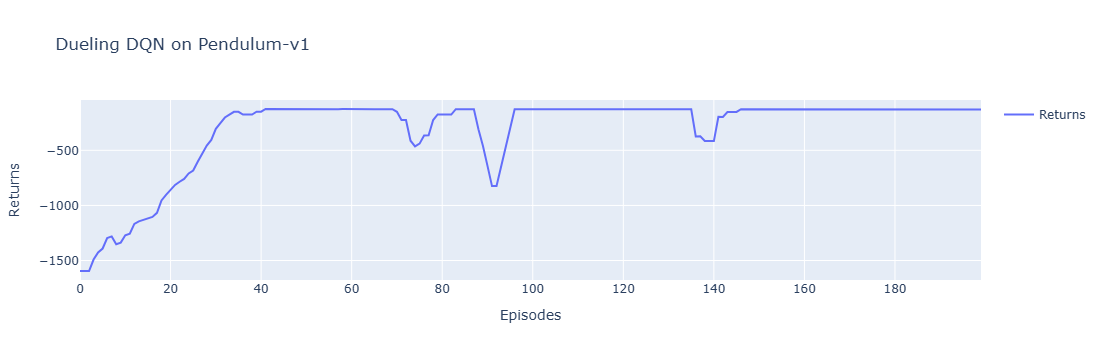

In [1]:
import plotly.graph_objects as go
import pandas as pd
df = pd.read_csv('DuelingDQN_returns_data.csv')  # 从 CSV 文件中读取数据
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Episodes'], y=df['Returns'], mode='lines', name='Returns'))
fig.update_layout(
    title='Dueling DQN on Pendulum-v1',
    xaxis_title='Episodes',
    yaxis_title='Returns',
    showlegend=True
)
fig.show()

In [12]:
import pandas as pd
frames_list = list(range(len(max_q_value_list)))
# 创建 DataFrame
df = pd.DataFrame({'Frames': frames_list, 'Q value': max_q_value_list})
# 保存为 CSV 文件
df.to_csv('DuelingDQN_mv_returns_data.csv', index=False)

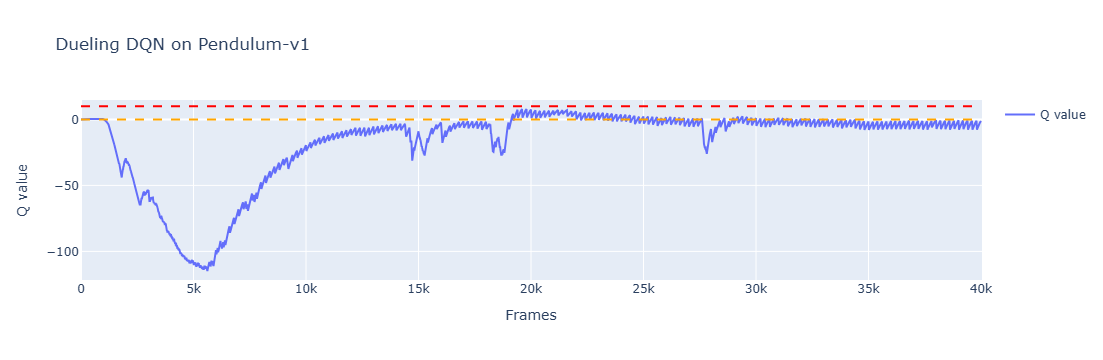

In [2]:
import plotly.graph_objects as go
import pandas as pd
df = pd.read_csv('DuelingDQN_mv_returns_data.csv')  # 从 CSV 文件中读取数据
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Frames'], y=df['Q value'], mode='lines', name='Q value'))

# 添加水平线 y=0
fig.add_shape(type='line',
              x0=df['Frames'].min(), x1=df['Frames'].max(),
              y0=0, y1=0,
              line=dict(color='orange', dash='dash'))

# 添加水平线 y=10
fig.add_shape(type='line',
              x0=df['Frames'].min(), x1=df['Frames'].max(),
              y0=10, y1=10,
              line=dict(color='red', dash='dash'))

fig.update_layout(
    title='Dueling DQN on Pendulum-v1',
    xaxis_title='Frames',
    yaxis_title='Q value',
    showlegend=True
)
fig.show()

> 可见，相比于传统的 DQN，Dueling DQN 在多个动作选择下的学习更加稳定
> 设计 Dueling DQN 网络架构是在强化学习的场景下，深度学习模型如何有效学习到有用模式的典范